https://adventofcode.com/2022/day/17

In [1]:
import numpy as np
from dataclasses import dataclass, field
from itertools import cycle
from typing import Generator
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

rock_masks = [
    np.array([[1, 1, 1, 1]]).T,
    np.array([[0, 1, 0],
              [1, 1, 1],
              [0, 1, 0]]).T,
    np.array([[0, 0, 1],
              [0, 0, 1],
              [1, 1, 1]]).T,
    np.array([[1],
              [1],
              [1],
              [1]]).T,
    np.array([[1, 1],
              [1, 1]]).T
]

@dataclass
class Rock():
    mask: np.ndarray
    loc: np.ndarray = None
        
    @property
    def coords(self):
        if self.loc is None:
            return None
        else:
            return tuple(i + j for i, j in zip(np.where(self.mask), self.loc))
        
    def __str__(self) -> str:
        return '\n'.join([''.join(row) for row in np.where(self.mask.T, '#', '.')])
    
    @property
    def locs(self):
        if self.loc is None:
            return None
        else:
            return np.array(list(zip(*self.coords)))
        
    @property
    def height(self):
        return self.mask.shape[1]

@dataclass
class Chamber():
    width: int
    height: int
    static_state: np.ndarray = field(init=False)
    active_rock: Rock = None
    rock_cycler: Generator = field(init=False)
    n_rocks: int = 0
    v_offset: int = 0
    buffer: list = field(init=False)
    hbuffer: list = field(init=False)
        
    def __post_init__(self):
        self.static_state = np.zeros((self.width, self.height), dtype=int)
        self.rock_cycler = cycle(rock_masks)
        self.add_rock()
        self.buffer = []
        self.hbuffer = []
        
    @property
    def state(self):
        state = np.copy(self.static_state)
        if self.active_rock:
            state[self.active_rock.coords] = 2
        return state
        
    def __str__(self) -> str:
        to_return = ''
        for row in self.state.T:
            to_return += '|'
            for i in row:
                match i:
                    case 0: # empty
                        to_return += '.'
                    case 1: # stationary rock
                        to_return += '#'
                    case 2: # falling rock
                        to_return += '@'
            to_return += '|\n'
        to_return += '+' + ''.join(['-']*(self.width)) + '+'
        return to_return
        
    def move_active_rock(self, vector):
        vector = np.array(vector)
        proposed_locs = self.active_rock.locs + vector
        if np.min(proposed_locs, axis=0)[0] < 0: return False
        if np.max(proposed_locs, axis=0)[0] >= self.width: return False
        if np.min(proposed_locs, axis=0)[1] >= self.height: return False
        if np.any(self.static_state[(proposed_locs[:,0], proposed_locs[:,1])]):
            return False
        else:
            self.active_rock.loc = self.active_rock.loc + vector
            return True
        
    def push_rock(self, direction: str):
        match direction:
            case '<':
                moved = self.move_active_rock([-1, 0])
            case '>':
                moved = self.move_active_rock([1, 0])
        return moved
    
    def drop_rock(self):
        return self.move_active_rock([0, 1])
    
    def set_active_rock_to_inactive(self):
        if not self.active_rock:
            raise ValueError
        self.static_state[self.active_rock.coords] = 1
        self.active_rock = None
        
    @property
    def rock_tower_height(self):
        max_rock_y = np.min(np.where(self.static_state == 1)[1], initial=self.height)
        return self.height - max_rock_y
    
    def add_rock(self, x=2, height=None):
        assert self.active_rock is None
        rock = Rock(next(self.rock_cycler))
        if not height:
            height = self.rock_tower_height + 3 + rock.height
        max_rock_height = self.height - height
        if max_rock_height < 0:
            self.shift_vertical_coordinate(-max_rock_height)
            max_rock_height = 0
        rock.loc = np.array((x, max_rock_height))
        self.active_rock = rock
        
    def update(self, push, n_rocks=2022, repeat=True):
        if repeat:
            generator = cycle(push)
        else:
            generator = push
        with tqdm(total=n_rocks) as pbar:
            for p in generator:
                self.push_rock(p)
                if not self.drop_rock():
                    old_height = self.rock_tower_height + self.v_offset
                    self.set_active_rock_to_inactive()
                    self.add_rock()
                    self.n_rocks += 1
                    new_height = self.rock_tower_height + self.v_offset
                    self.hbuffer.append(new_height-old_height)
                    pbar.update(1)
                    if self.n_rocks >= n_rocks:
                        break
                    
    def shift_vertical_coordinate(self, shift):
        self.static_state = np.roll(self.static_state, shift, axis=1)
        self.buffer.extend(np.packbits(self.static_state[:,:shift], axis=0)[0])
        self.static_state[:,:shift] = 0
        self.v_offset += shift
        
    @property
    def full_tower_height(self):
        return self.rock_tower_height + self.v_offset
                    
def read_input_data(filename):
    with open(filename, 'r') as f:
        data = f.readlines()[0]
    return data

def autocorrelation(signal: np.ndarray,
                     period: int,
                     offset: int=0) -> float:
    signal = np.array(signal)[offset:offset+period*2]
    x1 = signal[:period] / np.linalg.norm(signal[:period])
    x2 = signal[period:] / np.linalg.norm(signal[period:])
    return np.dot(x1,x2)

def height(n_rocks, hbuffer, offset, period):
    l = n_rocks - offset
    m = l // period
    r = l % period
    a = np.sum(hbuffer[:offset])
    b = np.sum(hbuffer[offset:offset+period])
    c = np.sum(hbuffer[offset:offset+r])
    return a + m*b + c

In [2]:
# part 1, example
filename = "../example_data/day17_example_data.txt"
jets = read_input_data(filename)
chamber = Chamber(width=7, height=100)
chamber.update(jets, n_rocks=2022)
print(chamber.full_tower_height)

  0%|          | 0/2022 [00:00<?, ?it/s]

3068


In [3]:
# part 1, solution
filename = "../data/day17_data.txt"
jets = read_input_data(filename)
chamber = Chamber(width=7, height=100)
chamber.update(jets, n_rocks=2022)
print(chamber.full_tower_height)

  0%|          | 0/2022 [00:00<?, ?it/s]

3147


## Part 2

We cannot brute force simulate 1,000,000,000,000 rocks falling. So we use the fact that the rock sequence and the jet sequence are periodic. So the arrangement of rocks (after some initial number of rocks) will also be periodic. And the *increase in height per block* will be periodic (after some initial number of rocks).

To start, rerun the part 1 simulations to obtain some example data.

In [4]:
# part 2, example
filename = "../example_data/day17_example_data.txt"
jets = read_input_data(filename)
chamber = Chamber(width=7, height=500)
chamber.update(jets, n_rocks=2022)
print(chamber.full_tower_height)

  0%|          | 0/2022 [00:00<?, ?it/s]

3068


The increase in tower height with each additional block is visibly periodic (after some initial time)

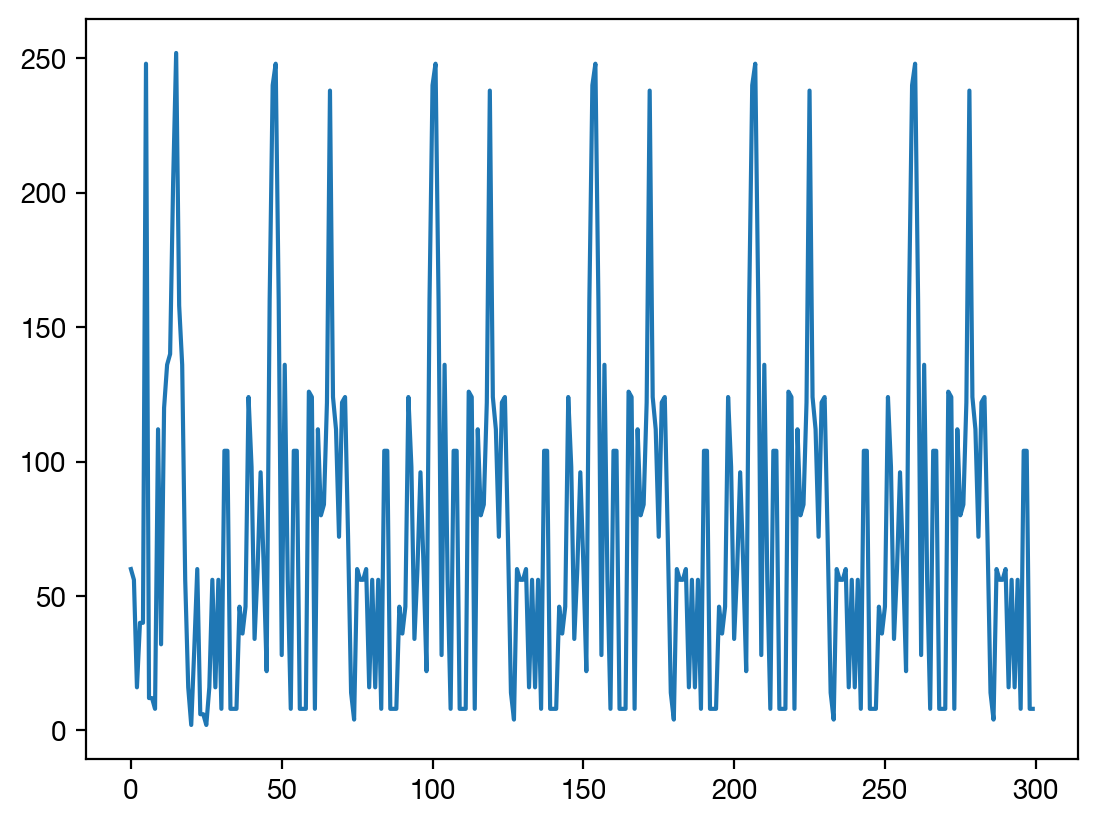

In [5]:
plt.plot(chamber.buffer[:300])
plt.show()

In [6]:
# We want the periodicity of the repeat unit, and the length of the initial section.

In [7]:
period = np.arange(10, 100)
correlation = np.array([autocorrelation(chamber.hbuffer, p, 50) for p in period])

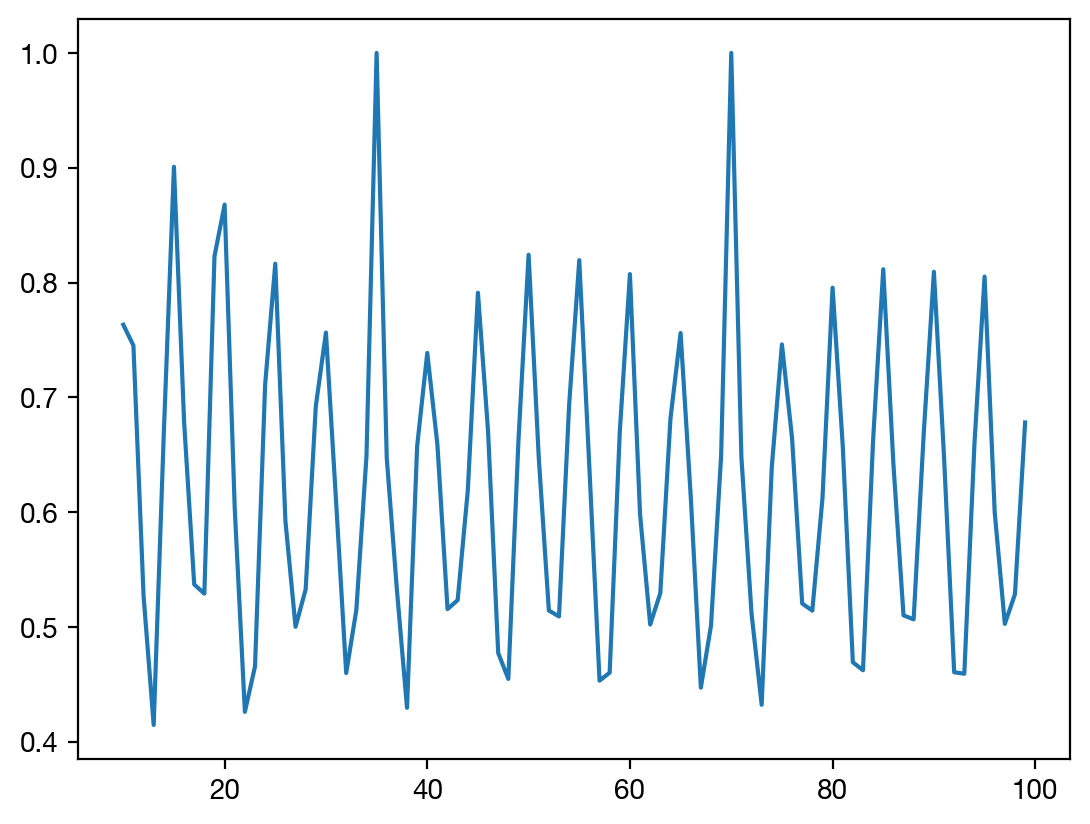

In [8]:
plt.plot(period, correlation)
plt.show()

We are periodic when the correlation = 1

In [9]:
rock_period = period[np.where(correlation == 1)[0][0]]
print(rock_period)

70


Find when we have sufficient lag from the start of the simulation for the correlation to converge to 1.

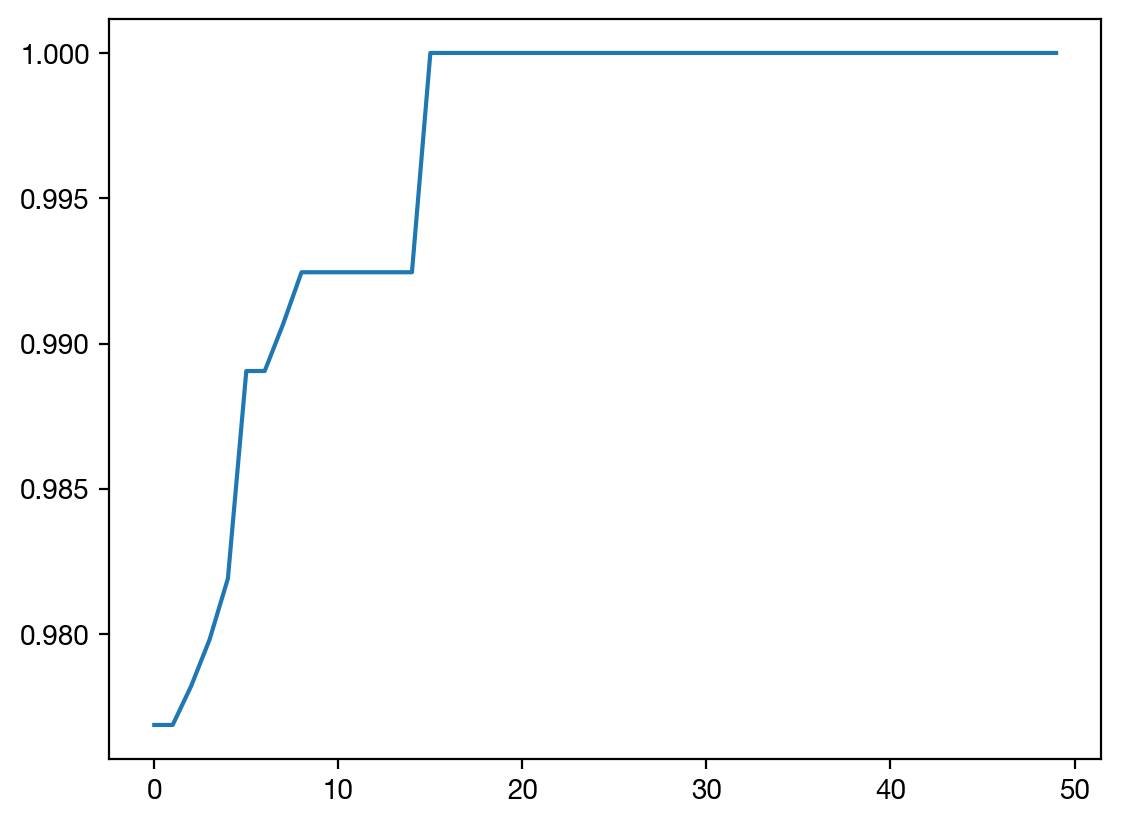

In [10]:
correlation = np.array([autocorrelation(chamber.hbuffer, rock_period, o) for o in range(50)])
plt.plot(correlation)
plt.show()

In [11]:
rock_offset = np.where(correlation == 1)[0][0]
rock_offset

15

We can recover the part 1 example result.

In [12]:
height(2022, chamber.hbuffer, rock_offset, rock_period)

3068

And the part 2 example result.

In [13]:
height(1000000000000, chamber.hbuffer, rock_offset, rock_period)

1514285714288

# Part 2 solution

In [14]:
# generate some data to process
filename = "../data/day17_data.txt"
jets = read_input_data(filename)
chamber = Chamber(width=7, height=500)
chamber.update(jets, n_rocks=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

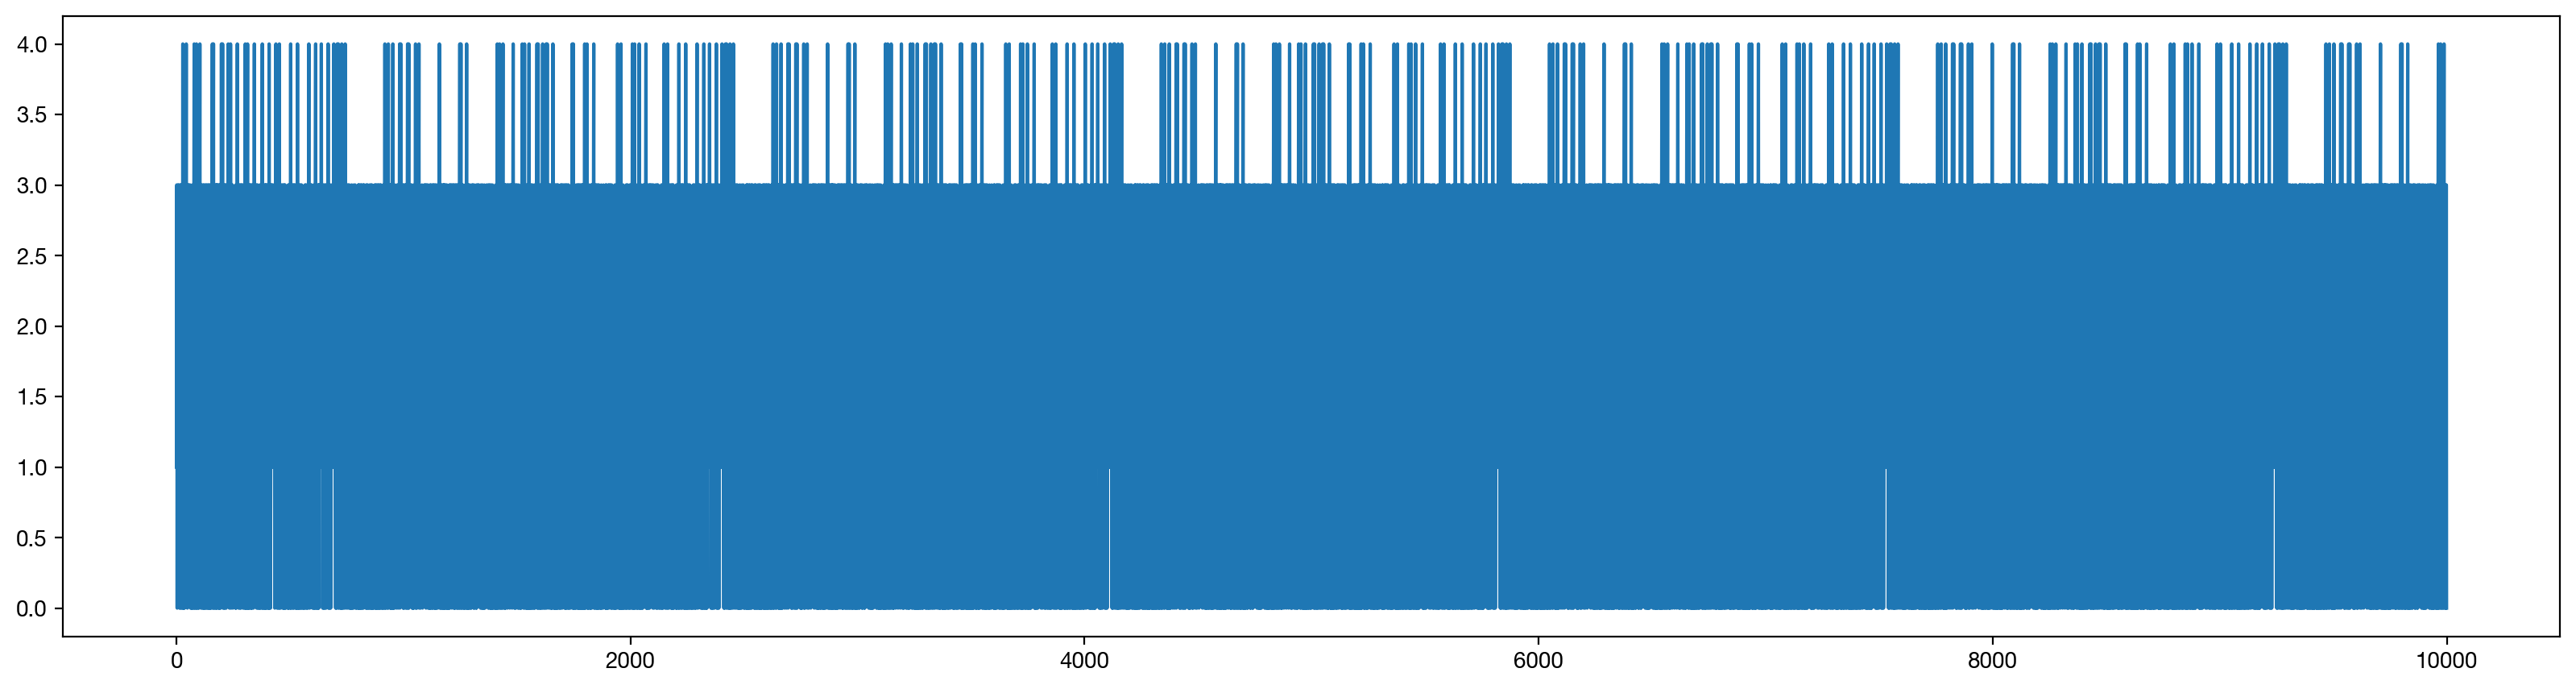

In [15]:
plt.figure(figsize=(20,5))
plt.plot(chamber.hbuffer)
plt.show()

In [16]:
period_array = np.arange(10, 2000)
correlation = np.array([autocorrelation(chamber.hbuffer, p, 1000) for p in period_array])

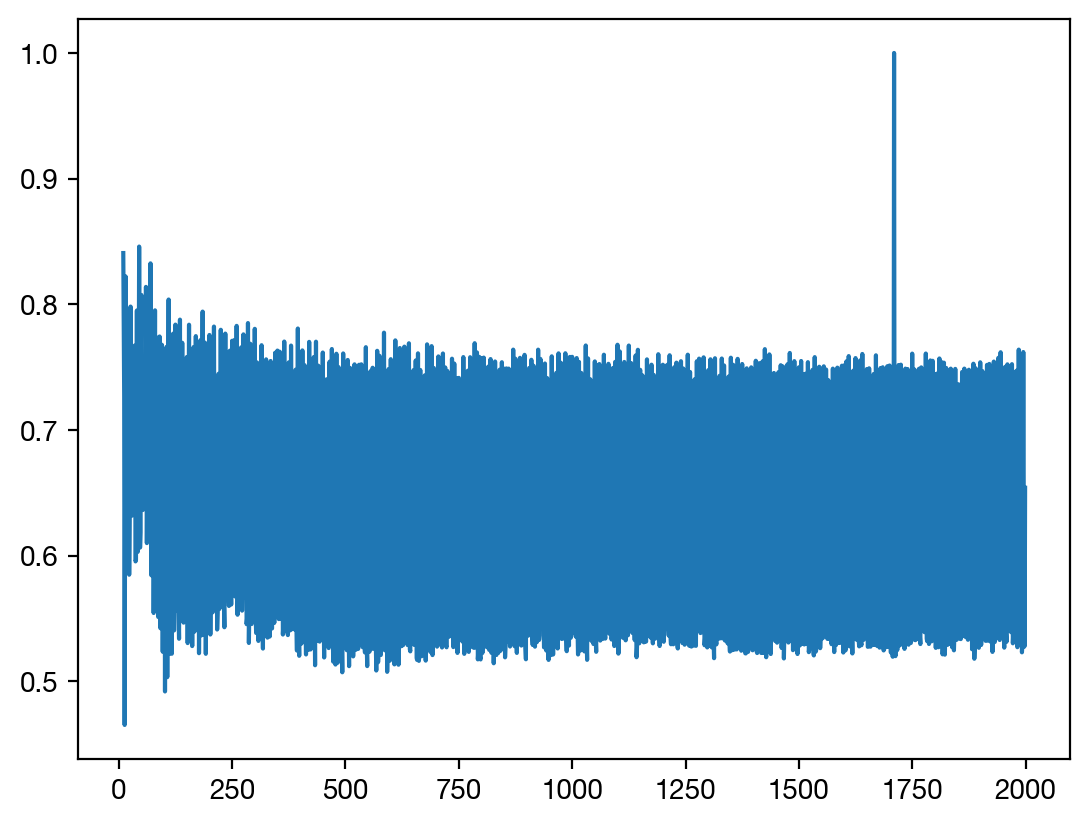

In [17]:
plt.plot(period_array, correlation)
plt.show()

In [18]:
rock_period = period_array[np.where(np.round(correlation, 4) == 1)[0][0]]
rock_period

1710

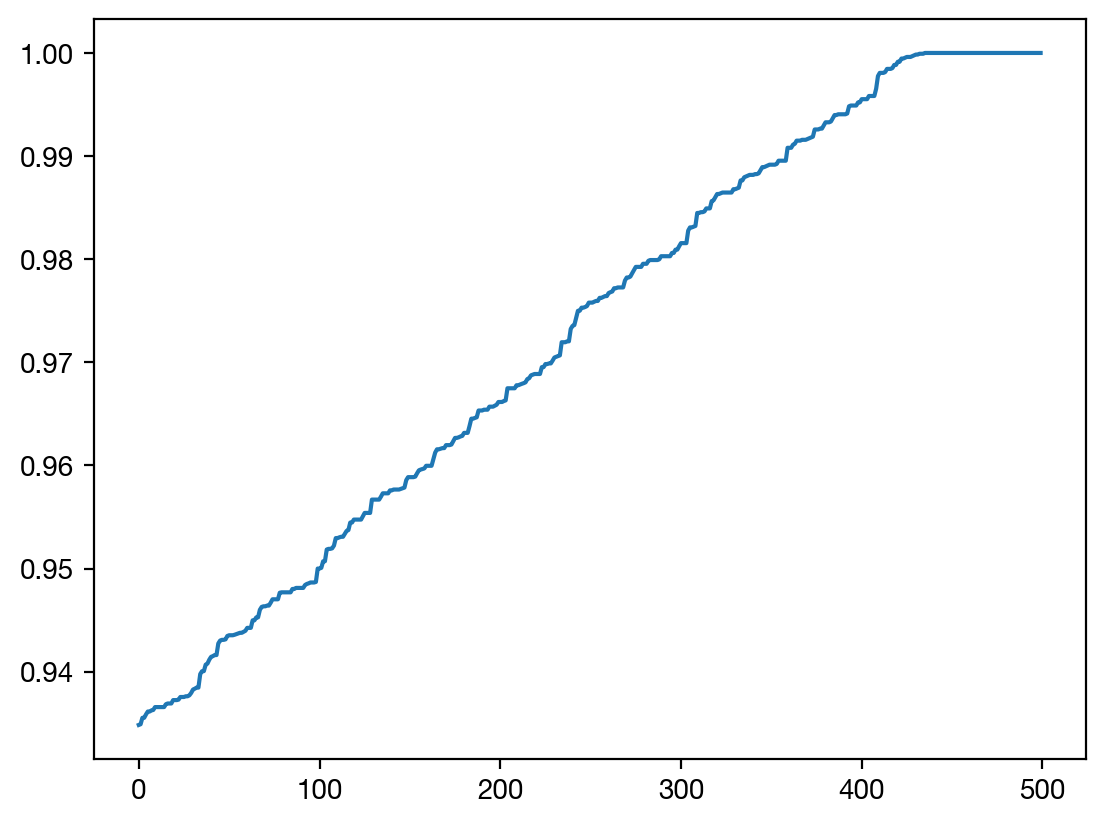

In [19]:
correlation = np.array([autocorrelation(chamber.hbuffer, rock_period, o) for o in range(500)])
plt.plot(correlation)
plt.show()

In [20]:
offset = np.where(correlation >= 1)[0][0]
offset

435

In [21]:
height(2022, chamber.hbuffer, offset, rock_period)

3147

In [22]:
height(1000000000000, chamber.hbuffer, offset, rock_period)

1532163742758